In [1]:
# this cell is for parallel computing, for it to work, 
# in a separate terminal "ipcluster start -n num_cores" must be executed

import ipyparallel as ipp
c = ipp.Client()
dview = c[:]

ModuleNotFoundError: No module named 'ipyparallel'

In [2]:
%%px --local

import trimesh as trm
import glob2
import numpy as np
import h5py
from tqdm import tqdm
import yaml
import datetime

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

/home/Albert.Matveev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [127]:
data_path = '/home/Albert.Matveev/sharp/abc_fine/obj_06/*/*.obj'

addrs = glob2.glob(data_path)

addrs_clean = []
for a in addrs:
    addrs_clean.append(a[43:-4]) # slice depends on the data path

addrs = np.array(addrs_clean) # get the addresses of the .obj files

In [128]:
addrs

array(['00061129/00061129_fdaa18af32bc49d79060b55e_trimesh_000',
       '00067083/00067083_3910595d1f1946bcb0e64969_trimesh_000',
       '00060793/00060793_b0c5cf989b8e4512a2c734f6_trimesh_008', ...,
       '00068954/00068954_aea16894921b459399d1a8af_trimesh_006',
       '00067710/00067710_d0e5b32b343c46b893a0c9d2_trimesh_000',
       '00062894/00062894_a14c883c56e34430b9cc2a57_trimesh_001'],
      dtype='<U54')

In [115]:
# the cell for filtering based on the ratio of faces with areas five times smaller than an average face area: 
# count these triangles

small_faces_rate_5 = []

for addr in tqdm(addrs):
    mesh = trm.load("abc_fine/obj_06/"+addr+".obj")
    small_faces_rate_5.append((mesh.area_faces < mesh.area_faces.mean()/5).mean())


  1%|▏         | 11/845 [00:02<03:42,  3.75it/s]
Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/Albert.Matveev/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/Albert.Matveev/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/Albert.Matveev/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 845/845 [06:11<00:00,  2.27it/s]


In [118]:
small_faces_rate_5 = np.array(small_faces_rate_5)

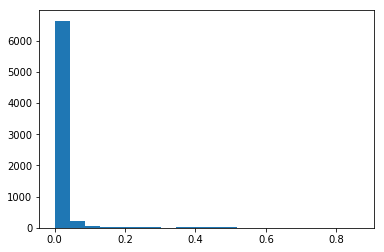

In [119]:
plt.hist(small_faces_rate_5, bins = 20)
plt.show()

In [120]:
print(small_faces_rate_5.max())
print(small_faces_rate_5.mean())

0.8641094749758962
0.013193521795201389


In [129]:
addrs_good_triangles = addrs[np.where(small_faces_rate_5 <= 0.05)[0]] # slice the addresses which have 
# big enough triangles (the rate of small triangles in the whole mesh is smaller than 5%)

In [136]:
# the cell for filtering based on the aspect ratio of faces: 
# count the number of triangles with aspect ratio more than 5

aspect_ratios_5 = []

for addr in tqdm(addrs_good_triangles):
    mesh = trm.load("abc_fine/obj_06/"+addr+".obj")
    vertices_in_edge = mesh.vertices[mesh.edges_unique[mesh.faces_unique_edges]]
    outer_radius = np.prod(np.sqrt(np.sum((vertices_in_edge[:,:,0]-vertices_in_edge[:,:,1]) ** 2, axis = -1)), 
            axis = -1) / 4 / mesh.area_faces
    half_perimeter = np.sqrt(np.sum((vertices_in_edge[:,:,0]-vertices_in_edge[:,:,1]) ** 2, 
                                    axis = -1)).sum(axis = -1) / 2
    inner_radius = mesh.area_faces / half_perimeter
    aspect_ratios_5.append((outer_radius / inner_radius >= 5).mean())

  1%|▏         | 89/6671 [00:30<37:06,  2.96it/s]/home/Albert.Matveev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/Albert.Matveev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
 10%|█         | 669/6671 [05:03<45:22,  2.20it/s]/home/Albert.Matveev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
100%|██████████| 6671/6671 [50:10<00:00,  2.22it/s]


In [137]:
aspect_ratios_5 = np.array(aspect_ratios_5)

In [138]:
print(aspect_ratios_5.max())
print(aspect_ratios_5.mean())

0.9956709956709957
0.003357746728420512


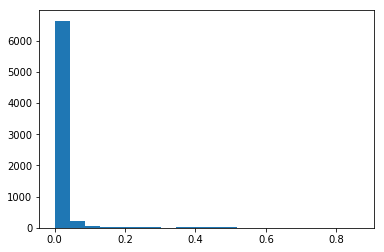

In [139]:
plt.hist(small_faces_rate_5, bins = 20)
plt.show()

In [140]:
(aspect_ratios_5 <= 0.05).sum()

6608

In [141]:
addrs_very_good_triangles = addrs_good_triangles[np.where(aspect_ratios_5 <= 0.05)[0]] # slice the addresses which have 
# good aspect ratio triangles (the rate of bad triangles in the whole mesh is smaller than 5%)

In [142]:
len(addrs_very_good_triangles)

6608

In [3]:
# save the names of good meshes: these files are available in the folder with datasets

file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_good_names.txt', 'w')
for addr in addrs_very_good_triangles:
    file.write('%s\n' % (addr))
file.close()

NameError: name 'addrs_very_good_triangles' is not defined

In [3]:
# %%px --local

names = []

file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_05_good_names.txt', 'r')
for addr in file:
    names.append(addr[:-1])
file.close()

file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_good_names.txt', 'r')
for addr in file:
    names.append(addr[:-1])
file.close()

names = np.array(names)

In [4]:
%%px --local

# the function for patch generator: breadth-first search

def find_and_add(sets, desired_number_of_points, adjacency_graph):
    counter = len(sets) # counter for number of verticess added to the patch;
    # sets is the list of vertices included to the patch
    for verts in sets:
        for vs in adjacency_graph.neighbors(verts):
            if vs not in sets:
                sets.append(vs)
                counter += 1
#                 print(counter)
        if counter >= desired_number_of_points:
            break # stop when the patch has more than 1024 vertices

In [5]:
%%px --local

def generate_patches(addrs_very_good_triangles):

    points = [] # for storing initial coordinates of points
    points_normalized = [] # for storing normalized coordinates of points
    labels = [] # for storing 0-1 labels for non-sharp/sharp points
    normals = []
    surface_rate = [] # for counting how many surfaces are there in the patch
    sharp_rate = [] # for indicator whether the oatch containes sharp vertices at all
    times = [] # for times (useless)
    p_names = [] # for names of the patches in the format "initial_mesh_name_N", where N is the starting vertex index
    desired_number_of_points = 1024

    for addr in tqdm(addrs_very_good_triangles):

        t_0 = datetime.datetime.now()
        
        if addr[:4] == '0005':
            folder = 'yml_05/'
        else: folder = 'yml_06/'

        yml = yaml.load(open('/home/Albert.Matveev/sharp/abc_fine/'+folder+addr[:-11]+'features'+addr[-4:]+'.yml', 'r'))

        t_yml_read = datetime.datetime.now()

        sharp_idx = []
        short_idx = []
        for i in yml['curves']:
            if len(i['vert_indices']) < 5: # this is for filtering based on short curves: 
                                           # append all the vertices which are in the curves with less than 5 vertices
                short_idx.append(np.array(i['vert_indices'])-1) # you need to substract 1 from vertex index, 
                                                                # since it starts with 1
            if ('sharp' in i.keys() and i['sharp'] == True):
                    sharp_idx.append(np.array(i['vert_indices'])-1) # append all the vertices which are marked as sharp
        if len(sharp_idx) > 0:
            sharp_idx = np.unique(np.concatenate(sharp_idx))
        if len(short_idx) > 0:
            short_idx = np.unique(np.concatenate(short_idx))

        t_curves_read = datetime.datetime.now()

        surfaces = []
        for i in yml['surfaces']:
                if 'vert_indices' in i.keys():
                    surfaces.append(np.array(i['face_indices']) - 1)

        t_surfaces_read = datetime.datetime.now()

        vertices = []
        faces = []
        if addr[:4] == '0005':
            folder = 'obj_05/'
        else: folder = 'obj_06/'
        
        for line in open("/home/Albert.Matveev/sharp/abc_fine/"+folder+addr+".obj", "r"): # read the mesh: since trimesh 
                                                                                          # messes the indices, 
                                                                                          # this has to be done manually
                values = line.split()
                if not values: continue
                if values[0] == 'v':
                    vertices.append(np.array(values[1:4], dtype = 'float'))
                elif values[0] == 'f':
                    faces.append(np.array([values[1].split('//')[0],values[2].split('//')[0], values[3].split('//')[0]], 
                                          dtype = 'int'))

        t_obj_read = datetime.datetime.now()

        vertices = np.array(vertices)
        faces = np.array(faces)-1
        sharp_indicator = np.zeros((len(vertices),))
        sharp_indicator[sharp_idx] = 1

        mesh = trm.base.Trimesh(vertices = vertices,faces = faces, process = False) # create a mesh from the vertices
                                                                                    # and faces read previously
        adjacency_graph = mesh.vertex_adjacency_graph

        t_mesh_read = datetime.datetime.now()

        for j in np.linspace(0, len(vertices), 7, dtype = 'int')[:-1]: # select starting vertices to grow patches from, 
                                                                       # while iterating over them use BFS to 
                                                                       # generate patches
#         for j in [529]:
            set_of_verts = [j]
            surfaces_numbers = []
            find_and_add(sets = set_of_verts, desired_number_of_points = desired_number_of_points,
                        adjacency_graph = adjacency_graph) # BFS function
            a = sharp_indicator[np.array(set_of_verts)[-100:]]
            b = np.isin(np.array(set_of_verts)[-100:],np.array(set_of_verts)[-100:]-1)
            if (a[b].sum() > 3):
#                 print('here! border!',j)
                continue
            set_of_verts = np.unique(np.array(set_of_verts)) # the resulting list of vertices in the patch
            if np.isin(set_of_verts, short_idx).any(): # discard a patch if there are short lines
                continue
            patch_vertices = mesh.vertices[set_of_verts]
            patch_sharp = sharp_indicator[set_of_verts]
            patch_normals = mesh.vertex_normals[set_of_verts]

            if patch_sharp.sum() != 0:
                sharp_rate.append(1)
            else: sharp_rate.append(0)

            if patch_vertices.shape[0] >= desired_number_of_points:
                # select those vertices, which are not sharp in order to use them for counting surfaces (sharp vertices
                # are counted twice, since they are on the border between two surfaces, hence they are discarded)
                appropriate_verts = set_of_verts[:desired_number_of_points][patch_sharp[:desired_number_of_points].astype(int) == 0]
                for surf_idx, surf_faces in enumerate(surfaces):
                        surf_verts = np.unique(mesh.faces[surf_faces].ravel())
                        if len(np.where(np.isin(appropriate_verts, surf_verts))[0]) > 0:
                            surface_ratio = sharp_indicator[np.unique(np.array(surf_verts))].sum()/len(np.unique(np.array(surf_verts)))
                            if (surface_ratio > 0.6):
                                break
                            surfaces_numbers.append(surf_idx) # write indices of surfaces which are present in the patch
                            continue
                if (surface_ratio > 0.6):
                    continue
                surface_rate.append(np.unique(np.array(surfaces_numbers)))
                patch_vertices = patch_vertices[:desired_number_of_points]
                points.append(patch_vertices)
                patch_vertices_normalized = patch_vertices - patch_vertices.mean(axis = 0)
                patch_vertices_normalized = patch_vertices_normalized / np.linalg.norm(patch_vertices_normalized, 
                                                                                       ord = 2, axis = 1).max()
                points_normalized.append(patch_vertices_normalized)
                patch_normals = patch_normals[:desired_number_of_points]
                normals.append(patch_normals)
                labels.append(patch_sharp[:desired_number_of_points])



                p_names.append('%s_%i' % (addr, j))

        t_patches_ready = datetime.datetime.now()
        times.append(np.array([(t_yml_read - t_0).microseconds, (t_curves_read - t_yml_read).microseconds,
                               (t_surfaces_read - t_curves_read).microseconds, (t_obj_read - t_surfaces_read).microseconds,
                               (t_mesh_read - t_obj_read).microseconds, (t_patches_ready - t_mesh_read).microseconds, 
                               (t_patches_ready - t_0).microseconds]))

    times = np.array(times)
    p_names = np.array(p_names)
    points = np.array(points)
    points_normalized = np.array(points_normalized)
    labels = np.array(labels).reshape(-1,1024,1)
    normals = np.array(normals)
    sharp_rate = np.array(sharp_rate)
    return times, p_names, points, points_normalized, labels, sharp_rate, surface_rate, normals

In [6]:
# parallel script

# to use parallelization, addresses have to be allocated to the cores
names_to_use = [names[:int(len(names)/6)], 
                names[int(len(names)/6):2*int(len(names)/6)],
                names[2*int(len(names)/6):3*int(len(names)/6)],
                names[3*int(len(names)/6):4*int(len(names)/6)],
                names[4*int(len(names)/6):5*int(len(names)/6)],
                names[5*int(len(names)/6):]]

f = dview.map(generate_patches, names_to_use) # parallel a function between the cores

t_start = datetime.datetime.now()
all_info = f.get() # run parallel script
t_end = datetime.datetime.now()

print((t_end - t_start))

# the output is a list of length num_cores, so to collect everything together:

times = np.concatenate([all_info[0][0],all_info[1][0],all_info[2][0],all_info[3][0],all_info[4][0],all_info[5][0]])
names = np.concatenate([all_info[0][1],all_info[1][1],all_info[2][1],all_info[3][1],all_info[4][1],all_info[5][1]])
points = np.concatenate([all_info[0][2],all_info[1][2],all_info[2][2],all_info[3][2],all_info[4][2],all_info[5][2]])
points_normalized = np.concatenate([all_info[0][3],all_info[1][3],all_info[2][3],all_info[3][3],all_info[4][3],all_info[5][3]])
points_normalized_noisy_point_01 = points_normalized + np.random.normal(0,0.01, points_normalized.shape)
points_normalized_noisy_point_001 = points_normalized + np.random.normal(0,0.001, points_normalized.shape)
labels = np.concatenate([all_info[0][4],all_info[1][4],all_info[2][4],all_info[3][4],all_info[4][4],all_info[5][4]])
sharp_rate = np.concatenate([all_info[0][5],all_info[1][5],all_info[2][5],all_info[3][5],all_info[4][5],all_info[5][5]])
surface_rate = np.concatenate([all_info[0][6],all_info[1][6],all_info[2][6],all_info[3][6],all_info[4][6],all_info[5][6]])
normals = np.concatenate([all_info[0][7],all_info[1][7],all_info[2][7],all_info[3][7],all_info[4][7],all_info[5][7]])

KeyboardInterrupt: 

In [ ]:
sharp_rate.sum()/len(sharp_rate)

In [12]:
all_info

[(array([[185471,    397,   1123, ..., 137749, 468789, 916033],
         [180757,    287,    484, ...,  43259, 482659, 761662],
         [205705,    211,   2552, ..., 273268, 538179, 349827],
         ...,
         [483416,    373,   2583, ..., 265107, 530603, 585404],
         [425217,   1162,   4021, ..., 391371, 576377, 874834],
         [814200,    248,   1126, ..., 106387, 501986, 554178]]),
  array(['00052059/00052059_0d6a2babe25f490fafec99fa_trimesh_000',
         '00053522/00053522_f565c574b5ff40a386622eec_trimesh_001',
         '00056263/00056263_d5d46f319cbc497d89007f95_trimesh_056', ...,
         '00068954/00068954_aea16894921b459399d1a8af_trimesh_006',
         '00067710/00067710_d0e5b32b343c46b893a0c9d2_trimesh_000',
         '00062894/00062894_a14c883c56e34430b9cc2a57_trimesh_001'],
        dtype='<U54'),
  array([[[ 4.8895000e+01,  0.0000000e+00, -5.2387500e+00],
          [ 3.6195000e+01,  0.0000000e+00, -5.2387500e+00],
          [ 3.9878099e+01, -3.2534070e+00, -4.762

In [ ]:
# non-parallel script

times, names, points, points_normalized, labels, sharp_rate, surface_rate = generate_patches(names)

In [33]:
labels = labels.reshape(-1,1024,1) # important to reshape the labels, otherwise the data provider 
                                   # of the networks messes the data

In [24]:
labels.shape

(73122, 1024, 1)

In [14]:
# count, how many surfaces are there in each patch

number_of_surfaces = []
for surf in surface_rate:
    number_of_surfaces.append(len(surf))
number_of_surfaces = np.array(number_of_surfaces)
print(number_of_surfaces.max())
print(number_of_surfaces.mean())

34
3.7817072837176227


In [40]:
number_of_surfaces[np.where(number_of_surfaces < 3)[0]].shape

(5384,)

create train/val/test splits and write them to hdf

In [18]:
points_train, points_test, \
points_normalized_train, points_normalized_test, \
points_normalized_noisy_point_01_train, points_normalized_noisy_point_01_test,\
points_normalized_noisy_point_001_train, points_normalized_noisy_point_001_test,\
labels_train, labels_test, normals_train, normals_test = train_test_split(points, points_normalized,
                                                                          points_normalized_noisy_point_01,
                                                                          points_normalized_noisy_point_001,
                                                                          labels, normals, 
                                                                          random_state = 42, test_size = 0.3)

In [19]:
normals_val, normals_test, \
points_val, points_test, \
points_normalized_val, points_normalized_test, \
points_normalized_noisy_point_01_val, points_normalized_noisy_point_01_test,\
points_normalized_noisy_point_001_val, points_normalized_noisy_point_001_test,\
labels_val, labels_test = train_test_split(normals_test, points_test, 
                                           points_normalized_test, 
                                           points_normalized_noisy_point_01_test,
                                           points_normalized_noisy_point_001_test,
                                           labels_test, 
                                           random_state = 42, test_size = 0.66)

In [21]:
hdf5_file = h5py.File('dataset_fine/abc_05_06_sharp_1024_patches_normalized_10pps_selected_short_with_normals.hdf5', mode='w')
hdf5_file.create_dataset("data", points_normalized.shape, np.float64)
hdf5_file["data"][...] = points_normalized
hdf5_file.create_dataset("data_noisy_01", points_normalized_noisy_point_01.shape, np.float64)
hdf5_file["data_noisy_01"][...] = points_normalized_noisy_point_01
hdf5_file.create_dataset("data_noisy_001", points_normalized_noisy_point_001.shape, np.float64)
hdf5_file["data_noisy_001"][...] = points_normalized_noisy_point_001
hdf5_file.create_dataset("points_original", points.shape, np.float64)
hdf5_file["points_original"][...] = points
hdf5_file.create_dataset("label", labels.shape, np.int)
hdf5_file["label"][...] = labels
hdf5_file.create_dataset("normal", normals.shape, np.int)
hdf5_file["normal"][...] = normals
hdf5_file.close()

In [44]:
hdf5_file = h5py.File('dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_train.hdf5', mode='w')
hdf5_file.create_dataset("data", points_normalized_train.shape, np.float64)
hdf5_file["data"][...] = points_normalized_train
hdf5_file.create_dataset("data_noisy_01", points_normalized_noisy_point_01_train.shape, np.float64)
hdf5_file["data_noisy_01"][...] = points_normalized_noisy_point_01_train
hdf5_file.create_dataset("data_noisy_001", points_normalized_noisy_point_001_train.shape, np.float64)
hdf5_file["data_noisy_001"][...] = points_normalized_noisy_point_001_train
hdf5_file.create_dataset("points_original", points_train.shape, np.float64)
hdf5_file["points_original"][...] = points_train
hdf5_file.create_dataset("label", labels_train.shape, np.int)
hdf5_file["label"][...] = labels_train
hdf5_file.close()

In [45]:
hdf5_file = h5py.File('dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_val.hdf5', mode='w')
hdf5_file.create_dataset("data", points_normalized_val.shape, np.float64)
hdf5_file["data"][...] = points_normalized_val
hdf5_file.create_dataset("data_noisy_01", points_normalized_noisy_point_01_val.shape, np.float64)
hdf5_file["data_noisy_01"][...] = points_normalized_noisy_point_01_val
hdf5_file.create_dataset("data_noisy_001", points_normalized_noisy_point_001_val.shape, np.float64)
hdf5_file["data_noisy_001"][...] = points_normalized_noisy_point_001_val
hdf5_file.create_dataset("points_original", points_val.shape, np.float64)
hdf5_file["points_original"][...] = points_val
hdf5_file.create_dataset("label", labels_val.shape, np.int)
hdf5_file["label"][...] = labels_val
hdf5_file.close()

In [46]:
hdf5_file = h5py.File('dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_test.hdf5', mode='w')
hdf5_file.create_dataset("data", points_normalized_test.shape, np.float64)
hdf5_file["data"][...] = points_normalized_test
hdf5_file.create_dataset("data_noisy_01", points_normalized_noisy_point_01_test.shape, np.float64)
hdf5_file["data_noisy_01"][...] = points_normalized_noisy_point_01_test
hdf5_file.create_dataset("data_noisy_001", points_normalized_noisy_point_001_test.shape, np.float64)
hdf5_file["data_noisy_001"][...] = points_normalized_noisy_point_001_test
hdf5_file.create_dataset("points_original", points_test.shape, np.float64)
hdf5_file["points_original"][...] = points_test
hdf5_file.create_dataset("label", labels_test.shape, np.int)
hdf5_file["label"][...] = labels_test
hdf5_file.close()

In [47]:
file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_names_train.txt', 'w')
for name in names_train:
    file.write('%s\n' % (name))
file.close()

file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_names_val.txt', 'w')
for name in names_val:
    file.write('%s\n' % (name))
file.close()

file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_names_test.txt', 'w')
for name in names_test:
    file.write('%s\n' % (name))
file.close()

In [66]:
file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_names.txt', 'w')
for name in names:
    file.write('%s\n' % (name))
file.close()

select the patches with desired number of surfaces in it, create trin/val/test splits and write them to hdf

In [25]:
good_surface_indices = [(number_of_surfaces >= 3) & (number_of_surfaces <=14)]

In [26]:
number_of_surfaces[good_surface_indices].shape

(47890,)

In [27]:
normals_good_surface = normals[good_surface_indices]
points_good_surface = points[good_surface_indices]
points_normalized_good_surface = points_normalized[good_surface_indices]
points_normalized_noisy_point_01_good_surface = points_normalized_noisy_point_01[good_surface_indices]
points_normalized_noisy_point_001_good_surface = points_normalized_noisy_point_001[good_surface_indices]
labels_good_surface = labels[good_surface_indices]

In [28]:
normals_train, normals_test, \
points_train, points_test, \
points_normalized_train, points_normalized_test, \
points_normalized_noisy_point_01_train, points_normalized_noisy_point_01_test,\
points_normalized_noisy_point_001_train, points_normalized_noisy_point_001_test,\
labels_train, labels_test = train_test_split(normals_good_surface, points_good_surface, points_normalized_good_surface,
                                             points_normalized_noisy_point_01_good_surface,
                                             points_normalized_noisy_point_001_good_surface,
                                            labels_good_surface, random_state = 42, test_size = 0.3)

In [29]:
normals_val, normals_test, \
points_val, points_test, \
points_normalized_val, points_normalized_test, \
points_normalized_noisy_point_01_val, points_normalized_noisy_point_01_test,\
points_normalized_noisy_point_001_val, points_normalized_noisy_point_001_test,\
labels_val, labels_test = train_test_split(normals_test, points_test, 
                                           points_normalized_test, 
                                           points_normalized_noisy_point_01_test,
                                           points_normalized_noisy_point_001_test,
                                           labels_test, 
                                           random_state = 42, test_size = 0.66)

In [35]:
points_train.shape

(33523, 1024, 3)

In [31]:
hdf5_file = h5py.File('dataset_fine/abc_05_06_sharp_1024_patches_normalized_10pps_selected_short_surfaces_with_normals.hdf5', mode='w')
hdf5_file.create_dataset("data", points_normalized_good_surface.shape, np.float64)
hdf5_file["data"][...] = points_normalized_good_surface
hdf5_file.create_dataset("data_noisy_01", points_normalized_noisy_point_01_good_surface.shape, np.float64)
hdf5_file["data_noisy_01"][...] = points_normalized_noisy_point_01_good_surface
hdf5_file.create_dataset("data_noisy_001", points_normalized_noisy_point_001_good_surface.shape, np.float64)
hdf5_file["data_noisy_001"][...] = points_normalized_noisy_point_001_good_surface
hdf5_file.create_dataset("points_original", points_good_surface.shape, np.float64)
hdf5_file["points_original"][...] = points_good_surface
hdf5_file.create_dataset("label", labels_good_surface.shape, np.int)
hdf5_file["label"][...] = labels_good_surface
hdf5_file.create_dataset("normal", normals_good_surface.shape, np.int)
hdf5_file["normal"][...] = normals_good_surface
hdf5_file.close()

In [36]:
hdf5_file = h5py.File('dataset_fine/abc_05_06_sharp_1024_patches_normalized_10pps_selected_short_surfaces_with_normals_small_train.hdf5', mode='w')
hdf5_file.create_dataset("data", points_normalized_train[:int(len(points_train)/3)].shape, np.float64)
hdf5_file["data"][...] = points_normalized_train[:int(len(points_train)/3)]
hdf5_file.create_dataset("data_noisy_01", points_normalized_noisy_point_01_train[:int(len(points_train)/3)].shape, np.float64)
hdf5_file["data_noisy_01"][...] = points_normalized_noisy_point_01_train[:int(len(points_train)/3)]
hdf5_file.create_dataset("data_noisy_001", points_normalized_noisy_point_001_train[:int(len(points_train)/3)].shape, np.float64)
hdf5_file["data_noisy_001"][...] = points_normalized_noisy_point_001_train[:int(len(points_train)/3)]
hdf5_file.create_dataset("points_original", points_train[:int(len(points_train)/3)].shape, np.float64)
hdf5_file["points_original"][...] = points_train[:int(len(points_train)/3)]
hdf5_file.create_dataset("label", labels_train[:int(len(points_train)/3)].shape, np.int)
hdf5_file["label"][...] = labels_train[:int(len(points_train)/3)]
hdf5_file.create_dataset("normal", normals_train[:int(len(points_train)/3)].shape, np.int)
hdf5_file["normal"][...] = normals_train[:int(len(points_train)/3)]
hdf5_file.close()

In [37]:
hdf5_file = h5py.File('dataset_fine/abc_05_06_sharp_1024_patches_normalized_10pps_selected_short_surfaces_with_normals_small_val.hdf5', mode='w')
hdf5_file.create_dataset("data", points_normalized_val[:int(len(points_val)/3)].shape, np.float64)
hdf5_file["data"][...] = points_normalized_val[:int(len(points_val)/3)]
hdf5_file.create_dataset("data_noisy_01", points_normalized_noisy_point_01_val[:int(len(points_val)/3)].shape, np.float64)
hdf5_file["data_noisy_01"][...] = points_normalized_noisy_point_01_val[:int(len(points_val)/3)]
hdf5_file.create_dataset("data_noisy_001", points_normalized_noisy_point_001_val[:int(len(points_val)/3)].shape, np.float64)
hdf5_file["data_noisy_001"][...] = points_normalized_noisy_point_001_val[:int(len(points_val)/3)]
hdf5_file.create_dataset("points_original", points_val[:int(len(points_val)/3)].shape, np.float64)
hdf5_file["points_original"][...] = points_val[:int(len(points_val)/3)]
hdf5_file.create_dataset("label", labels_val[:int(len(points_val)/3)].shape, np.int)
hdf5_file["label"][...] = labels_val[:int(len(points_val)/3)]
hdf5_file.create_dataset("normal", normals_val[:int(len(points_val)/3)].shape, np.int)
hdf5_file["normal"][...] = normals_val[:int(len(points_val)/3)]
hdf5_file.close()

In [38]:
hdf5_file = h5py.File('dataset_fine/abc_05_06_sharp_1024_patches_normalized_10pps_selected_short_surfaces_with_normals_small_test.hdf5', mode='w')
hdf5_file.create_dataset("data", points_normalized_test[:int(len(points_test)/3)].shape, np.float64)
hdf5_file["data"][...] = points_normalized_test[:int(len(points_test)/3)]
hdf5_file.create_dataset("data_noisy_01", points_normalized_noisy_point_01_test[:int(len(points_test)/3)].shape, np.float64)
hdf5_file["data_noisy_01"][...] = points_normalized_noisy_point_01_test[:int(len(points_test)/3)]
hdf5_file.create_dataset("data_noisy_001", points_normalized_noisy_point_001_test[:int(len(points_test)/3)].shape, np.float64)
hdf5_file["data_noisy_001"][...] = points_normalized_noisy_point_001_test[:int(len(points_test)/3)]
hdf5_file.create_dataset("points_original", points_test[:int(len(points_test)/3)].shape, np.float64)
hdf5_file["points_original"][...] = points_test[:int(len(points_test)/3)]
hdf5_file.create_dataset("label", labels_test[:int(len(points_test)/3)].shape, np.int)
hdf5_file["label"][...] = labels_test[:int(len(points_test)/3)]
hdf5_file.create_dataset("normal", normals_test[:int(len(points_test)/3)].shape, np.int)
hdf5_file["normal"][...] = normals_test[:int(len(points_test)/3)]
hdf5_file.close()

In [57]:
file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_selected_surfaces_names_train.txt', 'w')
for name in names_train:
    file.write('%s\n' % (name))
file.close()

file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_selected_surfaces_names_val.txt', 'w')
for name in names_val:
    file.write('%s\n' % (name))
file.close()

file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_selected_surfaces_names_test.txt', 'w')
for name in names_test:
    file.write('%s\n' % (name))
file.close()

In [67]:
file = open('/home/Albert.Matveev/sharp/dataset_fine/abc_06_sharp_1024_patches_normalized_4pps_selected_surfaces_names.txt', 'w')
for name in names_good_surface:
    file.write('%s\n' % (name))
file.close()

In [39]:
int(len(points_val))/3+int(len(points_test)/3)+int(len(points_train)/3)

15963.0

In [63]:
hdf5_file = h5py.File('dataset_fine/abc_05_sharp_1024_patches_normalized_4pps_selected_curves_surfaces_val.hdf5', mode='r')

In [64]:
hdf5_file['data'][0]

KeyError: "Unable to open object (object 'data' doesn't exist)"

In [65]:
hdf5_file.close()